In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_df(path, encoding="utf-8"):
    loaded_pd = pd.read_csv(path, sep="\t", encoding=encoding)
    pd_name = path.split("/")[-1].split(".")[0]
    return pd_name, loaded_pd

In [3]:
paths_expression = glob.glob("data/expression data/*.txt")

In [4]:
expression_data = []
for path in paths_expression:
    expression_data.append(load_df(path))

In [5]:
paths_other = glob.glob("data/*.txt")
aligner_path = "data/phenotypes_id_aligner.txt"
other_data = []
for path in paths_other:
    if path == aligner_path:
        other_data.append(load_df(path, encoding="latin"))
    else:
        other_data.append(load_df(path))

## We have loaded the dataframes to lists

Each list contains tuples (name, dataframe)
- expression_data: tables with gene expressions
- other_data: all the remaining tables

In [6]:
# Compute the total set of mice strains present in the expressions dataframes
mice_set = set()

for i in range(len(expression_data)):
    df = expression_data[i][1].set_index('gene')
    mice_set.update(list(df.columns))

# Compute the total list of mice strains sorted alphabetically
mice_list = sorted(list(mice_set))
print(len(mice_list))

97


In [7]:
# Create a list of dataframes that always contain all mice (with NaN values if the mice are not originally present)
df_list = []

for i in range(len(expression_data)):
    df = expression_data[i][1].set_index('gene')
    # standardize to fight the issue of different means and deviations - to make all of the values comparable
    df = df.sub(df.mean(1), axis=0).div(df.std(1), axis=0)
    missing_mice = mice_set - set(df.columns)
    for mouse in missing_mice:
        df[mouse] = np.NaN
        
    # Order the columns alphabetically
    df = df[mice_list]
    df.reset_index(inplace=True)
    df["gene"] = df["gene"].apply(lambda name: name + "_" + expression_data[i][0])
    df.rename(columns={"gene": "strain"}, inplace=True)
    df.set_index("strain", inplace=True)
    df_list.append(df.transpose())

In [8]:
base_df = df_list[0]
for other_df in df_list[1:]:
    base_df = base_df.join(other_df)

We note that all in all the tissues apart from [9, 14, 16, 17, 22, 26, 27, 30, 31, 32, 34, 35, 37, 38, 39] the values appear to follow normal distribution. To make all of them comparable we standardize them by (SNP, tissue)

In [9]:
gene_tissue_num = len(base_df.columns)

In [10]:
# we remove the mice for which we have no expression data whatsoever
base_df.drop(base_df[base_df.isnull().sum(axis=1) == gene_tissue_num].index, inplace=True)

We remove the (SNP, tissue) for which we do not have data for at least 4 mice

In [11]:
strains_num = len(base_df)

In [12]:
columns_to_drop = base_df.columns[base_df.isnull().sum(axis=0) > strains_num - 4]

In [13]:
base_df.drop(columns_to_drop, axis=1, inplace=True)

In [14]:
base_df.to_pickle("processed_data/expression_standardized_cleaned.pkl")

In [15]:
phenotype_present = pd.read_pickle("processed_data/pheno_joined_present.pkl")

In [16]:
strains_with_pheno = phenotype_present.columns[:-2]

In [17]:
base_df = base_df.transpose()
base_df.rename(columns={"strain": "SNP"})

,B6D2F1,BXD1,BXD100,BXD101,BXD102,BXD11,BXD12,BXD13,BXD14,BXD15,...,BXD9,BXD90,BXD93,BXD94,BXD95,BXD98,BXD99,C57BL.6J,D2B6F1,DBA.2J
strain,,,,,,,,,,,,,,,,,,,,,
Nmt1_10338077_Muscle_CD,NaN,NaN,-0.725161,-1.317918,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.792381,NaN,NaN,-1.360695,2.220295,-1.305697,-1.929009,NaN,-0.156847
Psmb5_10338095_Muscle_CD,NaN,NaN,0.007720,1.462562,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.067101,NaN,NaN,-0.649038,-1.073020,0.207241,-0.557591,NaN,1.263041
Hdac5_10338098_Muscle_CD,NaN,NaN,0.376058,0.845329,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.774767,NaN,NaN,0.854019,0.193564,1.453644,-0.353919,NaN,1.831667
Dlg1_10338109_Muscle_CD,NaN,NaN,0.545516,0.515211,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.444705,NaN,NaN,-1.347606,0.252363,0.255455,-0.014195,NaN,-0.289412
Wars_10338116_Muscle_CD,NaN,NaN,-1.104466,-1.058281,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.304157,NaN,NaN,1.089291,1.052343,-0.748846,0.050143,NaN,-0.166923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tfrc_AFFX-TransRecMur-X57349_5_at_Eye,1.036264,-0.566462,NaN,NaN,NaN,-1.180697,0.207761,-1.209266,0.464883,-0.372192,...,-0.672167,2.201883,NaN,NaN,NaN,-0.740733,-0.757874,0.979126,0.744860,-0.297912
Tfrc_AFFX-TransRecMur-X57349_M_at_Eye,1.008312,-0.427261,NaN,NaN,NaN,-1.017522,-0.143061,-1.494832,0.312387,-0.740610,...,-1.046671,2.043091,NaN,NaN,NaN,-0.645876,0.082841,0.822489,0.724112,0.039118
AFFX-TrpnX-3_AFFX-TrpnX-3_at_Eye,-0.810138,-0.273595,NaN,NaN,NaN,1.964559,-1.530640,-0.258265,1.596643,0.845482,...,-1.346682,-0.258265,NaN,NaN,NaN,-0.672170,-0.610851,-1.086075,-0.518872,-0.334914


In [18]:
strain_with_pheno = []
for index, row in phenotype_present.iterrows():
    strain_with_pheno.append(row[~row.isnull()].index.tolist()[:-2])

# Malaria Susceptibility regression baseline

We decide to replace the missing values with mean. This is for simplicity.

In [19]:
df_pheno = []
base_df = base_df.T
for index, row in phenotype_present.iterrows():
    row = row[~row.isna()]
    row_df = pd.DataFrame(row)
    column_name = row_df.columns[0]
    row_df.rename(columns={column_name: row["Shown_pheno"]}, inplace=True)
    df_pheno.append(base_df.join(row_df, how="inner"))

In [20]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

In [21]:
pheno_idx_of_interest = [0, 1, 2, 3, -1, -2]
malaria_susceptibility_idx = [-1]

In [22]:
import random
positive_test_score = 0
num_tests = 20
for random_state in range(num_tests):
    for pheno_idx in malaria_susceptibility_idx:    
        X_train, X_test, y_train, y_test = train_test_split(
            df_pheno[pheno_idx].iloc[:, :-1].fillna(0), df_pheno[pheno_idx].iloc[:, -1].fillna(0), test_size=0.3, random_state=random_state)

        clf = RidgeCV(alphas=[1e-99, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12]).fit(X_train, y_train)
        if (clf.alpha_ == 1e12 or clf.alpha_ == 1e-5):
            print(clf.alpha_)
            print("Might need to update alpha")
        test_score = clf.score(X_test, y_test)
        if test_score > 0:
            positive_test_score += 1
        print(f"{df_pheno[pheno_idx].columns[-1]}, test+score: {test_score}, number_of_samples: {len(df_pheno[pheno_idx])}")
print(f"percentage of positive R^2 scores: {float(positive_test_score) / num_tests * 100}")

Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.10180054576041642, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.13969175139595935, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.1279596132381915, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.16958417245691593, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.2751187703390876, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: -0.07999826243561435, number_of_samples: 57
Malar

We conclude that The ridge regression classifier does better than it would by always guessing the expected value, so it is a good baseline and the phenotype appears to be somewhat predictible give the gene expression data.

In [23]:
# we compare ridge regression with expected value error
df_malaria = df_pheno[-1]

In [24]:
df_malaria.to_pickle("processed_data/malaria_susceptibility.pkl")

In [25]:
X_train, y_train = df_malaria.iloc[:, :-1].fillna(0), df_malaria.iloc[:, -1].fillna(0)
clf_alpha = RidgeCV(alphas=np.linspace(7000, 7049, 1000), store_cv_values=True).fit(X_train, y_train)
print(f"best alpha: {clf_alpha.alpha_}")

best alpha: 7033.794794794795


In [26]:
clf = RidgeCV(alphas=[clf_alpha.alpha_], store_cv_values=True).fit(X_train, y_train)

print(f"{df_malaria.columns[-1]}, number_of_samples: {len(df_malaria)}")
print(f"mean error: {clf.cv_values_.mean()}")
print(f"mean error for completely susceptible mice: {clf.cv_values_[np.where(y_train == 1.0)[0]].mean()}")
print(f"mean error for somewhat resistant mice: {clf.cv_values_[np.where(y_train != 1.0)[0]].mean()}")

Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], number_of_samples: 57
mean error: 0.11434224449086289
mean error for completely susceptible mice: 0.0662065340169772
mean error for somewhat resistant mice: 0.16419708748167308


Text(0.5, 0, 'malaria susceptibility %')

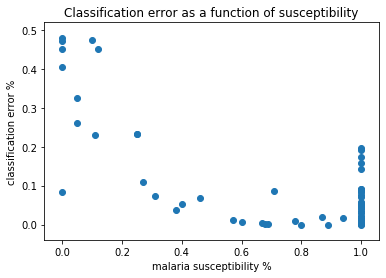

In [27]:
# error distribution by mice susceptibility
plt.scatter(x=y_train, y=clf.cv_values_)
plt.title("Classification error as a function of susceptibility")
plt.ylabel("classification error %")
plt.xlabel("malaria susceptibility %")

We note that the classifier makes the worst mistakes when predicting susceptibility of the most resistant mice.

(array([9.00000e+00, 2.02000e+02, 4.57100e+03, 8.31610e+04, 5.60186e+05,
        4.96384e+05, 5.36320e+04, 2.80700e+03, 2.57000e+02, 2.20000e+01]),
 array([-2.55293652e-05, -2.03659262e-05, -1.52024872e-05, -1.00390482e-05,
        -4.87560913e-06,  2.87829891e-07,  5.45126891e-06,  1.06147079e-05,
         1.57781470e-05,  2.09415860e-05,  2.61050250e-05]),
 <a list of 10 Patch objects>)

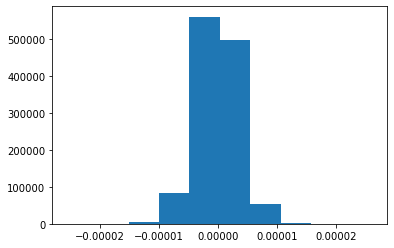

In [28]:
plt.hist(clf.coef_)

Most of the weights are very small, meaning most of the expression data is not used. It appears that there are both gene expressions that correlate with susceptibility as those related to resistance: the histogram has negative and positive entries.

SNPs used by classifier to predict susceptibility:

In [29]:
X_train.columns[np.where(clf.coef_ > 0.000023)[0]]

Index(['scl00280487.1_157-S_ILM5910112_Bone_Femur',
       '1700072I22Rik_ILM100380731_Bone_Femur', 'Cpn1_ILM1940114_Bone_Femur',
       'Lonp2_ILM5290687_Bone_Femur', 'Serpina1-rat_ILM106590035_Bone_Femur'],
      dtype='object')

SNPs used by classifier to predict resistance:

In [30]:
X_train.columns[np.where(clf.coef_ < -0.0000215)[0]]

Index(['Gpr83_ILM102940402_Bone_Femur', 'Cntnap2_ILM100380601_Bone_Femur',
       'Car10_ILM3130463_Bone_Femur', 'Nppc_ILM2320647_Bone_Femur',
       '4930571N24Rik_ILM101230041_Bone_Femur'],
      dtype='object')

It seems that gene expression in bone femur is the strongest indicator

We decide to reduce the number of SNPs we use for prediction for computational efficiency. To select the most important ones we pick those that have highest or lowest weights in ridge regression and those that have highest or lowest spearman correlation. Note that there might be more complex relationships that we decide not to consider due to limited number of mice in the dataset.

In [31]:
coef_with_index = list(zip(range(clf.coef_.shape[0]), clf.coef_))

In [32]:
coef_with_index.sort(key=lambda x: x[1])

In [33]:
# pick k indices of the most relevant features according to ridge
def relevant_indices(k, list_with_indices):
    negative = [el[0] for el in list_with_indices[:k//2]]
    positive = [el[0] for el in list_with_indices[-k//2:]]
    return negative + positive

In [49]:
def evaluate_ridge(X_train_eval):
    alphas = np.linspace(1e-10, 1000, 1500)
    clf_ridge_relevant = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_train_eval, y_train)
    best_alpha_index = np.where(alphas == clf_ridge_relevant.alpha_)[0]
    print(f"best alpha: {clf_ridge_relevant.alpha_}")
    print(f"mean error: {clf_ridge_relevant.cv_values_[:, ].mean()}")

In [50]:
indices_to_evaluate = [X_train.shape[1], 1e5, 50000, 1e4, 1e3, 1e2]
for k in indices_to_evaluate:
    print(f"SNPs used: {int(k)}")
    indices = relevant_indices(int(k), coef_with_index)
    evaluate_ridge(X_train.iloc[:, indices])

SNPs used: 1201231
best alpha: 1000.0
mean error: 0.11441279741829025
SNPs used: 100000
best alpha: 1e-10
mean error: 0.01328558974279297
SNPs used: 50000
best alpha: 1e-10
mean error: 0.013108024727601399
SNPs used: 10000
best alpha: 1e-10
mean error: 0.03172777976580277
SNPs used: 1000
best alpha: 4.669779853335023
mean error: 0.05478505288300855
SNPs used: 100
best alpha: 76.05070046707039
mean error: 0.11688487699548336


We see that actually best scores are attained when we use only 100k most relevant SNPs, and using only 1k gives results not much worse. We decide to use only 1k for easier computation and better interpretability. 

Other measures of feature importance can be used. Here we compute the spearman correlation and pick the SNPs most positively or negatively correlated with the malaric susceptibility.

In [36]:
from scipy.stats import spearmanr

In [37]:
import timeit
number_of_samples = X_train.shape[1]
spearman_values = []
start = timeit.default_timer()
for i in range(X_train.shape[1]):
     spearman_values.append(spearmanr(X_train.iloc[:,i], y_train)[0])
print(f"Time: {timeit.default_timer() - start}")

Time: 623.7729175329999


In [38]:
spearman_values = np.array(spearman_values)
np.save("processed_data/spearman_SNP_susceptibility.npy", spearman_values)

In [39]:
spearman_with_index = list(zip(range(spearman_values.shape[0]), spearman_values))
spearman_with_index.sort(key=lambda x: x[1])

In [51]:
for k in indices_to_evaluate:
    print(f"SNPs used: {int(k)}")
    indices = relevant_indices(int(k), spearman_with_index)
    evaluate_ridge(X_train.iloc[:, indices])

SNPs used: 1201231
best alpha: 1000.0
mean error: 0.11441279741829082
SNPs used: 100000
best alpha: 1000.0
mean error: 0.04271160180741342
SNPs used: 50000
best alpha: 1000.0
mean error: 0.042063967372120925
SNPs used: 10000
best alpha: 932.6217478318947
mean error: 0.03571977156676771
SNPs used: 1000
best alpha: 130.75383589068065
mean error: 0.04382821423413428
SNPs used: 100
best alpha: 36.69112741837518
mean error: 0.06916577163298071


In [52]:
indices_both = list(set(relevant_indices(400, spearman_with_index) + relevant_indices(400, coef_with_index)))
evaluate_ridge(X_train.iloc[:, indices_both])
pd.to_pickle(df_pheno[-1].iloc[:, :-1].iloc[:, indices_both], "processed_data/selected_features.pkl")

best alpha: 70.71380920623035
mean error: 0.03105023943991126


We note that taking only the SNPs with significant spearman correlation doesn't give better results, but combining some of them with those previously selected does help. Since taking only

Test of random forest regressor. As can be seen, it did not perform as well and we decided not to pursue this direction, using ridge regression only in the end.

In [42]:
from sklearn.ensemble import RandomForestRegressor
positive_test_score = 0
num_tests = 20
for random_state in range(num_tests):
    for pheno_idx in malaria_susceptibility_idx:    
        X_train, X_test, y_train, y_test = train_test_split(
            df_pheno[pheno_idx].iloc[:, :-1].fillna(0), df_pheno[pheno_idx].iloc[:, -1].fillna(0), test_size=0.3, random_state=random_state)

        clf = RandomForestRegressor(max_depth=10, random_state=0)
        clf.fit(X_train.iloc[:, indices_both], y_train)
        test_score = clf.score(X_test.iloc[:, indices_both], y_test)
        if test_score > 0:
            positive_test_score += 1
        print(f"{df_pheno[pheno_idx].columns[-1]}, test+score: {test_score}, number_of_samples: {len(df_pheno[pheno_idx])}")
print(f"percentage of positive R^2 scores: {float(positive_test_score) / num_tests * 100}")

Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.5753575724464473, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.68657994779008, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.5786920518322878, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.503845055202111, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.493124536944389, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.03176701281484706, number_of_samples: 57
Malaria susce

Testing the model with only selected features. We see that it performs much better.

In [43]:
positive_test_score = 0
num_tests = 20
for random_state in range(num_tests):
    for pheno_idx in malaria_susceptibility_idx:    
        X_train, X_test, y_train, y_test = train_test_split(
            df_pheno[pheno_idx].iloc[:, :-1].fillna(0), df_pheno[pheno_idx].iloc[:, -1].fillna(0), test_size=0.3, random_state=random_state)

        clf = RidgeCV(store_cv_values=True, alphas=[1e-99, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12]).fit(X_train.iloc[:, indices_both], y_train)
        if (clf.alpha_ == 1e12 or clf.alpha_ == 1e-5):
            print(clf.alpha_)
            print("Might need to update alpha")
        test_score = clf.score(X_test.iloc[:, indices_both], y_test)
        if test_score > 0:
            positive_test_score += 1
        print(f"{df_pheno[pheno_idx].columns[-1]}, test+score: {test_score}, number_of_samples: {len(df_pheno[pheno_idx])}")
print(f"percentage of positive R^2 scores: {float(positive_test_score) / num_tests * 100}")

Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.8070006754865492, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.878495403891756, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.7708790128025225, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.5744964561652144, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.8143591532790926, number_of_samples: 57
Malaria susceptibility, murine Plasmodium yoelli 17X-lethal (PY17X-L) [0=100% resistant, 1= 100% susceptible], test+score: 0.7522962378892999, number_of_samples: 57
Malaria sus

In [44]:
X_train, y_train = df_malaria.iloc[:, :-1].fillna(0), df_malaria.iloc[:, -1].fillna(0)

In [45]:
clf.fit(X_train.iloc[:, indices_both], y_train);

Text(0.5, 0, 'malaria susceptibility %')

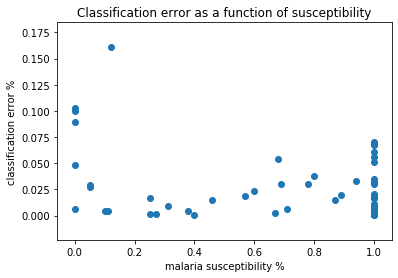

In [46]:
# error distribution by mice susceptibility
plt.scatter(x=y_train, y=clf.cv_values_[:,0])
plt.title("Classification error as a function of susceptibility")
plt.ylabel("classification error %")
plt.xlabel("malaria susceptibility %")

Clearly this model is very accurate on the data